# Calculating the Radius from transit depth

You Belong With Me
****

Importing Modules

In [1]:
import astropy.constants as const
import Gridingtons as grid
import matplotlib.figure as fig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
from pylab import arange,pi,sin,cos,sqrt
import scipy.stats as stats
import seaborn as sns
from WhatisLife import Rotator

In [2]:
%matplotlib notebook
π = np.pi
Colour = plt.style.use('tableau-colorblind10')

In [3]:
def ScreamExtractor(File, Sep=','):
    FILENAME = pd.read_csv(f'{File}', sep=Sep)
    return FILENAME

In [240]:
Directory = 'C:/Users/georg/Documents/GitHub/Iwan-and-George-Year-4-Project'
PlanetData = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Planets/Final Planets.csv').dropna(ignore_index=True)
GaiaDatat = ScreamExtractor(f'{Directory}/BASTA/Input/Gaia.txt', '\t').dropna(ignore_index=True)
GaiaData2t = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Stars/Gaia All Stars.csv').dropna(ignore_index=True)
BASTAData = ScreamExtractor(f'{Directory}/BASTA/Output/GaiaResultsFinal.ascii', '\t').dropna(ignore_index=True)
FultonData = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Stars/Fulton All Stars.csv').dropna(ignore_index=True)
VanEylenData = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Stars/VanEylen All Stars.csv').dropna(ignore_index=True)
HRData = ScreamExtractor(f'{Directory}/Samples/Raw Data/HR Data.csv').dropna(ignore_index=True)

In [241]:
FultonData = pd.concat([FultonData, VanEylenData], ignore_index=True)

In [242]:
GaiaData = pd.DataFrame()
GaiaData2 = pd.DataFrame()
for g in range(len(BASTAData)):
    try:
        Line = GaiaDatat[GaiaDatat['# ID'] == BASTAData['starid'][g]]
        GaiaData = pd.concat([GaiaData, Line], ignore_index=True)
    except:
        continue

    try:
        Line = GaiaData2t[GaiaData2t['Gaia DR3 ID'] == BASTAData['starid'][g]]
        GaiaData2 = pd.concat([GaiaData2, Line], ignore_index=True)
    except:
        continue
del GaiaDatat, GaiaData2t

In [243]:
GaiaData2['Rad pe'] += 0.035*GaiaData2['Radius']
GaiaData2['Rad me'] += 0.035*GaiaData2['Radius']
GaiaData2['Teff pe'] = np.sqrt(GaiaData2['Teff pe']**2 + 102**2)
GaiaData2['Teff me'] = np.sqrt(GaiaData2['Teff me']**2 + 102**2)

In [244]:
def PlanetRadiusErrors(Ratio, Radius, RatioError, RadiusError):
    Error = np.sqrt((Ratio*RadiusError)**2 + (Radius*RatioError)**2)*const.R_sun/const.R_earth
    return Error

In [245]:
def PlanetRadiusFinder(Planets, Stars, BASTAfication='Post'):
    if BASTAfication == 'Pre':
        ID = 'Gaia DR3 ID'
        Radii = 'Radius'
        Radiierrp = 'Rad pe'
        Radiierrm = 'Rad me'
    else:
        ID = 'starid'
        Radii = 'radPhot'
        Radiierrp = 'radPhot_errp'
        Radiierrm = 'radPhot_errm'
    
    Period = []
    PlanetRadius = []
    PlanetRadiuserrp = []
    PlanetRadiuserrm = []
    IndexList = []
    for n in range(len(Planets)):
        try:
            Index = Stars[Stars[ID] == Planets['Host Gaia DR3 ID'][n]].index[0]
            Radius = Planets['PSR'][n]*Stars[Radii][Index]*const.R_sun/const.R_earth
            if Radius < 4:
                IndexList.append(Index)
                Period.append(Planets['P'][n])
                PlanetRadius.append(Radius)

                PlanetRadiuserrp.append(PlanetRadiusErrors(Planets['PSR'][n], Stars[Radii][Index],
                                                           Planets['PSR pme'][n], Stars[Radiierrp][Index]))
                PlanetRadiuserrm.append(PlanetRadiusErrors(Planets['PSR'][n], Stars[Radii][Index],
                                                           Planets['PSR pme'][n], Stars[Radiierrm][Index]))
        except:
            continue
    return Period, PlanetRadius, [PlanetRadiuserrp, PlanetRadiuserrm], IndexList

In [246]:
PeriodBASTA, RadiusBASTA, RadiusBASTAerr, IndexBASTA = PlanetRadiusFinder(PlanetData, BASTAData)
PeriodGaia, RadiusGaia, RadiusGaiaerr, IndexGaia = PlanetRadiusFinder(PlanetData, GaiaData2, 'Pre')

In [247]:
UsedStars = BASTAData.iloc[IndexBASTA,:]

In [248]:
Test = UsedStars.drop_duplicates(subset='starid')

In [ ]:
Title = 'Radius Valley plot for Gaia Stars and VanHo Planets'
'''
plt.figure()
plt.errorbar(PeriodGaia, RadiusGaia, yerr=RadiusGaiaerr,
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia')
plt.errorbar(PeriodBASTA, RadiusBASTA, yerr=RadiusBASTAerr,
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia)')
plt.xscale('log')
plt.xlabel('log(Orbital Period/Days)', fontsize=12)
plt.ylabel('$R/R_{\oplus}$', fontsize=12)
plt.title(Title, fontsize=15)
plt.legend()
plt.show()
'''
#sns.jointplot(x=np.log10(PeriodGaia), y=np.array(RadiusGaia), joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
sns.jointplot(x=np.log10(PeriodBASTA), y=np.array(RadiusBASTA), joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
plt.show()

In [155]:
def Gradienter(XAxis, YAxis, m, N, width=0.3, X=10):
    NewX = np.linspace(X, X, len(XAxis))
    NewY = 10**(m*(np.log10(X)-np.log10(XAxis))+np.log10(YAxis))
    Radii = []
    for r in range(len(NewY)):
        if NewY[r] > 0 and NewY[r] < 4:
            Radii.append(NewY[r])

    g = sns.kdeplot(Radii, bw_adjust=width).lines[N]
    plt.xlabel(r'$R_p/R_{\oplus}$', fontsize=15)
    x2, y2 = g.get_data()
    
    Min = 10**(m*(np.log10(X))+0.22)
    Max = 10**(m*(np.log10(X))+0.32)
    #plt.plot([Min, Min], [min(y2), max(y2)], '--', color='red')
    #plt.plot([Max, Max], [min(y2), max(y2)], '--', color='green')
    Minimum = []
    Minimumx = []
    for n in range(len(x2)):
        if x2[n] > Min and x2[n] < Max:
            Minimum.append(y2[n])
            Minimumx.append(x2[n])
    
    try:
        Valleyy = min(Minimum)
        ValleyIndex = Minimum.index(Valleyy)
        Valleyx = Minimumx[ValleyIndex]

        Earthy = 0
        Neptuney = 0
        for t in range(len(x2)):
            if y2[t] > Earthy and x2[t] < Valleyx:
                Earthy = y2[t]
            elif y2[t] > Neptuney and x2[t] > Valleyx:
                Neptuney = y2[t]

        Ratio = (Earthy + Neptuney)/2/Valleyy
    
    except:
        print('No minimum for ', m)
        Ratio = 0
        Valleyx = 0
    
    return Ratio, Valleyx

In [74]:
XAxis = list(UsedStars['massfin'])

In [75]:
def KDEezNuts(w, Iteration):
    RatioList = []
    ValleyxList = []
    for l in range(len(Gradients)):
        Ratio, Valleyx = Gradienter(np.array(XAxis), np.array(RadiusBASTA), Gradients[l], Iteration, width=w)
        Iteration += 1
        RatioList.append(Ratio)
        ValleyxList.append(Valleyx)

    return RatioList, ValleyxList, Iteration

<IPython.core.display.Javascript object>


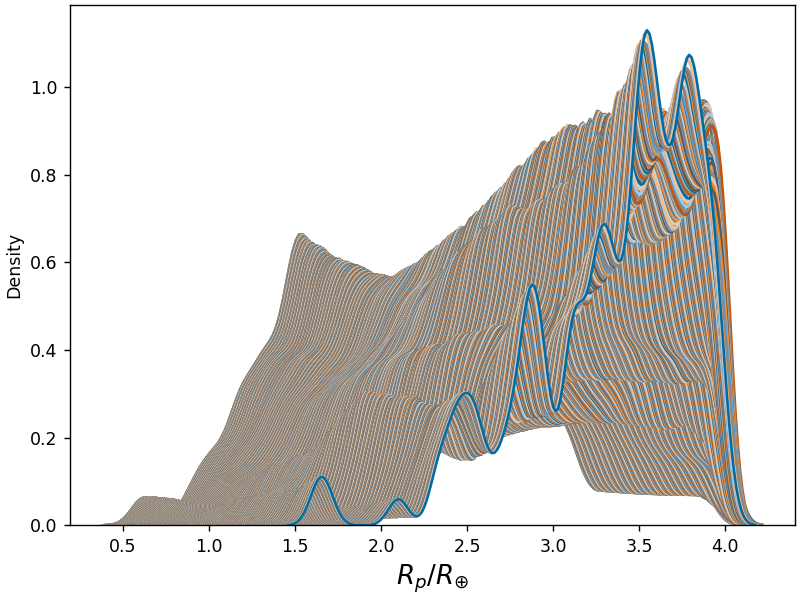

100.0 %


In [96]:
Gradients = np.linspace(0, 0.4, 1001)
Widths = np.linspace(0.3, 0.3, 1)
plt.figure(constrained_layout=True)

ModelList = []
cList = []
Iteration = -1
for w in range(len(Widths)):
    Iteration += 1
    RatioList, ValleyxList, Iteration = KDEezNuts(Widths[w], Iteration)
    Iteration -= 1
    
    Index = RatioList.index(max(RatioList))
    Model = Gradients[Index]
    ModelList.append(Model)
    c = -Model*(np.log10(10))+np.log10(ValleyxList[Index])
    cList.append(c)
    print(round((w+1)/len(Widths)*100, 1), '%')

plt.show()
Title = 'One KDE for Radius'
#plt.savefig(f'{Directory}/Plots/Report Plots/{Title}.pdf')

In [249]:
def Model(x, m, c):
    return 10**(m*np.log10(x) + c)

def Inverse(y, m, c):
    return 10**((np.log10(y)-c)/m)

In [250]:
#Index = RatioList.index(max(RatioList))

x = np.linspace(min(XAxis), max(XAxis), 2)
m1 = -0.11
#m2 = Gradients[Index]
c1 = 0.37
#c2 = -m2*(np.log10(10))+np.log10(ValleyxList[Index])
y1 = Model(x, m1, c1)
#y2 = Model(x, m2, c2)

In [99]:
print(m2)
print(c2)

0.3184
0.3012496358932122


In [100]:
Earths = []
Neptunes = []
EarthsErrp = []
EarthsErrm = []
NeptunesErrp = []
NeptunesErrm = []
EarthsErrp2 = []
EarthsErrm2 = []
NeptunesErrp2 = []
NeptunesErrm2 = []
for n in range(len(XAxis)):
    X = XAxis[n]
    Y = RadiusBASTA[n]
    Errp = np.array(RadiusBASTAerr)[0, n]
    Errm = np.array(RadiusBASTAerr)[1, n]
    ModelY = Model(X, m2, c2)
    ModelX = Inverse(Y, m2, c2)
    if Y < ModelY:
        Earths.append([X, Y])
        EarthsErrp.append(Errp)
        EarthsErrm.append(Errm)
        EarthsErrp2.append(list(UsedStars['massfin_errp'])[n])
        EarthsErrm2.append(list(UsedStars['massfin_errm'])[n])
    else:
        Neptunes.append([X, Y])
        NeptunesErrp.append(Errp)
        NeptunesErrm.append(Errm)
        NeptunesErrp2.append(list(UsedStars['massfin_errp'])[n])
        NeptunesErrm2.append(list(UsedStars['massfin_errm'])[n])

<IPython.core.display.Javascript object>


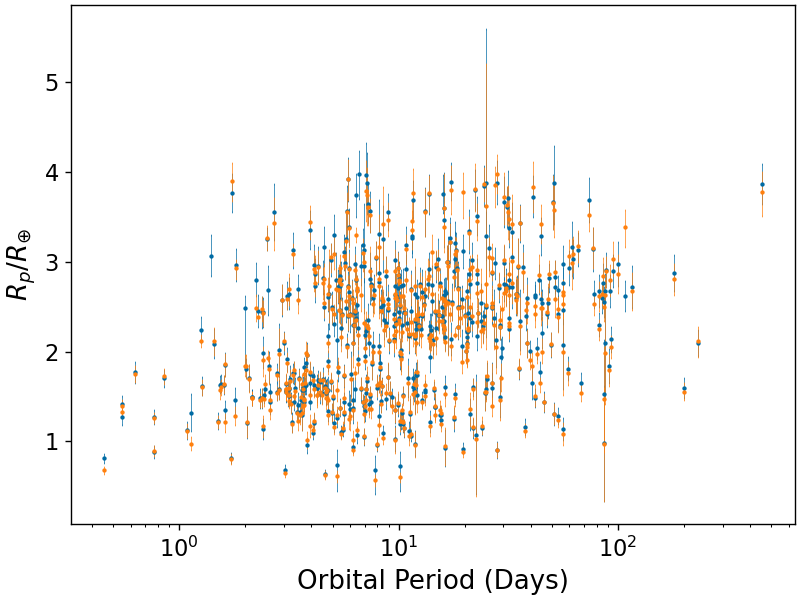

In [251]:
Title='Radius Valley Plot'

plt.figure(constrained_layout=True)
plt.errorbar(PeriodGaia, RadiusGaia, yerr=RadiusGaiaerr, elinewidth=0.4,
             capsize=0.2, fmt='.', color=Colour, markersize=3, label='Pre BASTA')
plt.errorbar(PeriodBASTA, RadiusBASTA, yerr=RadiusBASTAerr, elinewidth=0.4,
             capsize=0.2, fmt='.', color=Colour, markersize=3, label='Post BASTA')
'''plt.errorbar(np.array(Earths)[:,0], np.array(Earths)[:,1], xerr=[EarthsErrp2, EarthsErrm2],
             yerr=[EarthsErrp, EarthsErrm],
             elinewidth=0.2, capsize=0.2, fmt='.', color='green', markersize=3, label='Earths')
plt.errorbar(np.array(Neptunes)[:,0], np.array(Neptunes)[:,1], xerr=[NeptunesErrp2, NeptunesErrm2],
             yerr=[NeptunesErrp, NeptunesErrm],
             elinewidth=0.2, capsize=0.2, fmt='.', color='blue', markersize=3, label='Neptunes')'''
#plt.plot(x, y1, color=Colour, label='Ho & Van Eylen Model')
#plt.plot(Inverse(y2, m2, c2), Model(x, m2, c2), color='orange', label='Our Model')
plt.xlabel('Orbital Period (Days)', fontsize=15)
plt.ylabel(r'$R_p/R_{\oplus}$', fontsize=15)
plt.tick_params(labelsize=13)
#plt.title(Title, fontsize=12)
plt.xscale('log')
#plt.ylim(0, 5)
#plt.xlim(0.6, 1.4)
#plt.legend(fontsize=12)
plt.show()
#plt.savefig(f'{Directory}/Plots/Report Plots/{Title}.pdf')

In [252]:
AllData = ScreamExtractor(f'{Directory}/Results/All Planets.txt').dropna(ignore_index=True)
ExoData = ScreamExtractor(f'{Directory}/Results/Exo Planets.txt').dropna(ignore_index=True)
HoVanData = ScreamExtractor(f'{Directory}/Results/HoVan Planets.txt').dropna(ignore_index=True)

In [253]:
AllData.columns[0][11:-1]
All = []
for n in range(len(AllData.columns)):
    All.append(float(AllData.columns[n][11:-2]))

Exo = []
for n in range(len(ExoData.columns)):
    Exo.append(float(ExoData.columns[n][11:-2]))

HoVan = []
for n in range(len(HoVanData.columns)):
    HoVan.append(float(HoVanData.columns[n][11:-2]))

In [255]:
Test

,starid,Teff,Teff_errp,Teff_errm,FeH,FeH_errp,FeH_errm,radPhot,radPhot_errp,radPhot_errm,...,massfin_errm,age,age_errp,age_errm,numax,numax_errp,numax_errm,dnuscal,dnuscal_errp,dnuscal_errm
4,111322601672419712,5265.610561,49.299269,58.167389,-0.016058,0.121050,0.103025,1.005791,0.054937,0.068153,...,0.045945,17744.957570,1580.920960,2726.128230,2710.382202,350.150343,273.744626,123.325027,12.154477,9.307509
12,145333927996558976,4119.011103,8.886089,7.044182,0.292230,0.081341,0.016047,0.618400,0.008320,0.008491,...,0.000026,3152.694932,2728.049988,2127.291454,6753.406518,186.327731,168.910954,233.494562,4.760497,4.396669
14,1476485996883837184,4676.405969,63.679697,62.105416,-0.004849,0.107217,0.104540,0.723807,0.024270,0.028034,...,0.020163,11022.437880,5866.656920,6944.306304,4860.308786,359.605160,308.704679,188.938045,10.763092,9.039749
15,148080473682357376,3879.201994,49.973975,65.282612,-0.300100,0.100300,0.100400,0.407269,0.026771,0.019361,...,0.020039,9600.000000,6500.000000,6500.000000,10060.692053,530.150844,672.257284,345.766976,18.252087,23.459638
33,2051027792165858304,4632.105951,59.840839,63.593482,-0.077039,0.094916,0.089029,0.687717,0.026528,0.020644,...,0.015990,7051.081039,5976.853881,4954.975952,5272.699211,283.355750,340.293178,201.506229,8.466633,10.370349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,6258364939144564992,3983.217221,2.939685,4.192538,0.478738,0.004348,0.005900,0.596101,0.003472,0.001332,...,0.000009,1921.747540,1552.000000,1164.000000,7408.797289,32.478684,90.253294,246.976407,0.831135,2.143653
535,6258810550587404672,5758.967068,108.312925,110.381889,-0.206702,0.142335,0.142645,1.465860,0.112320,0.098616,...,0.070992,10688.840860,1994.977130,1716.101568,1330.707236,220.443024,186.462121,73.161623,8.543462,7.663017
536,6264513270727342080,4126.190870,21.499381,19.780067,0.326563,0.079563,0.049542,0.630276,0.014171,0.012492,...,0.004040,5128.973717,4813.721215,3528.957995,6555.838615,239.303693,250.413260,227.845832,6.511655,6.697664
549,6541360574788758016,4736.770341,67.657626,59.531337,0.072983,0.110650,0.113037,0.747739,0.026761,0.030012,...,0.033206,10577.011330,6300.922090,6092.181760,4658.464019,356.785093,313.208409,182.522914,10.606932,8.875242


In [323]:
np.median(Test['age'])

9264.981178

<IPython.core.display.Javascript object>


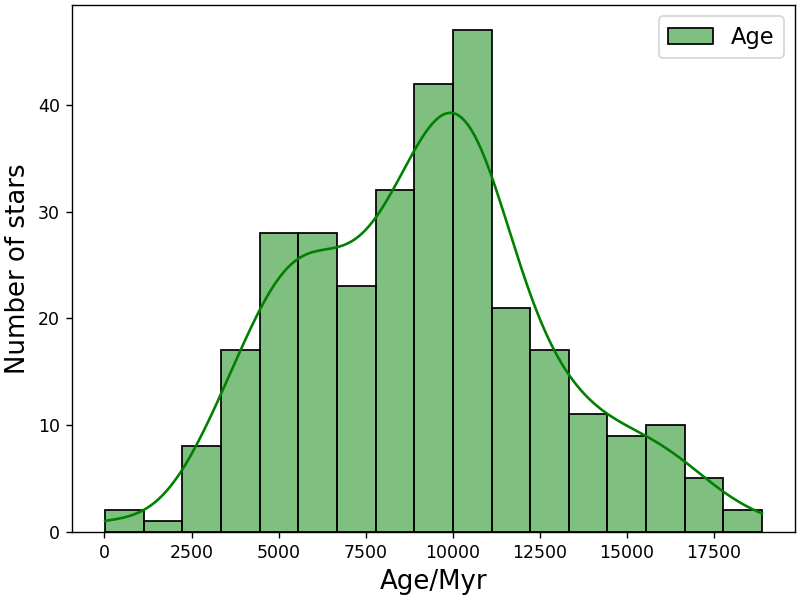

In [329]:
Bins = 17

plt.figure(constrained_layout=True)
p = sns.histplot(Test['age'], color='green', bins=Bins, kde=True, label='Age')
plt.xlabel('Age/Myr', fontsize=15)
plt.ylabel('Number of stars', fontsize=15)
plt.legend(fontsize=13)
plt.show()

Title = 'Star Distribution - Age'
plt.savefig(f'{Directory}/Plots/Report Plots/{Title}.pdf')

In [175]:
'''TempFile = open(f'{Directory}/Results/HoVan Planets.txt', 'w')
TempFile.write(str(RadiusBASTA))
TempFile.close()'''

In [103]:
SolarTemp = 5772
def LuminosityErrors(Radius, Teff, RadiusError, TeffError):
    Error = 2*Radius*Teff**3/SolarTemp**4*np.sqrt(Teff**2*RadiusError**2 + 4*Radius**2*TeffError**2)
    return Error

In [104]:
LuminosityGaia = GaiaData2['Radius']**2*(GaiaData2['Teff']/SolarTemp)**4
LuminosityBASTA = BASTAData['radPhot']**2*(BASTAData['Teff']/SolarTemp)**4
LuminosityFulton = FultonData['Radius']**2*(FultonData['Teff']/SolarTemp)**4
LuminosityGaiaerrp = LuminosityErrors(GaiaData2['Radius'], GaiaData2['Teff'], 
                                       GaiaData2['Rad pe'], GaiaData2['Teff pe'])
LuminosityGaiaerrm = LuminosityErrors(GaiaData2['Radius'], GaiaData2['Teff'], 
                                       GaiaData2['Rad me'], GaiaData2['Teff me'])
LuminosityBASTAerrp = LuminosityErrors(BASTAData['radPhot'], BASTAData['Teff'], 
                                       BASTAData['radPhot_errp'], BASTAData['Teff_errp'])
LuminosityBASTAerrm = LuminosityErrors(BASTAData['radPhot'], BASTAData['Teff'], 
                                       BASTAData['radPhot_errm'], BASTAData['Teff_errm'])
LuminosityFultonerrp = LuminosityErrors(FultonData['Radius'], FultonData['Teff'], 
                                       FultonData['Rad pe'], FultonData['Teff pe'])
LuminosityFultonerrm = LuminosityErrors(FultonData['Radius'], FultonData['Teff'], 
                                       FultonData['Rad me'], FultonData['Teff me'])

In [ ]:
#!python numbers=disable
# 500.484 for single 0.8 scale
# 240.23016 for doublen 0.48 scale
fig_width_pt = 240.23016  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]


<IPython.core.display.Javascript object>


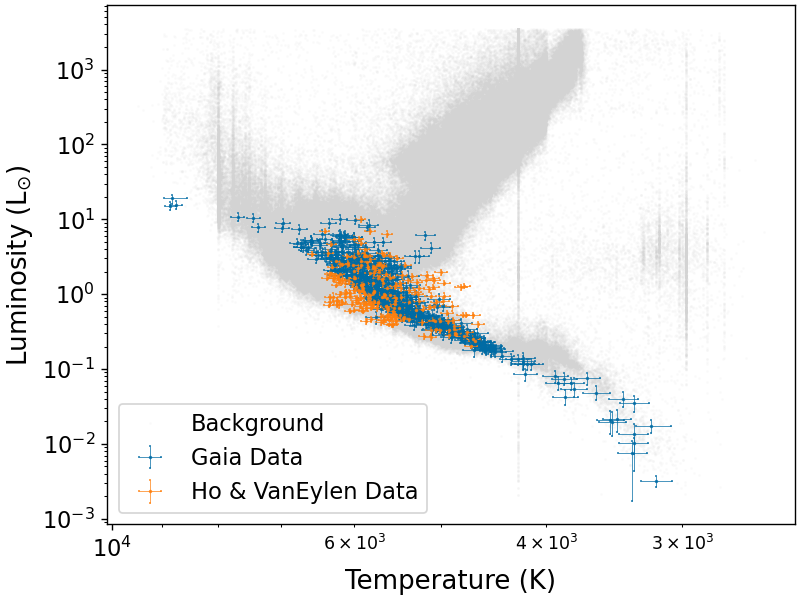

In [112]:
Title = 'HR Diagram showing the different Samples'

fig = plt.figure(constrained_layout=True)
#fig.set_size_inches(*figsize)
plt.plot(HRData['Teff'], HRData['Luminosity'], '.', color='lightgrey',
         markersize=1, label='Background', rasterized=True, alpha=0.1)
plt.errorbar(GaiaData2['Teff'], LuminosityGaia, xerr=[GaiaData2['Teff pe'], GaiaData2['Teff me']],
             yerr=[LuminosityGaiaerrp, LuminosityGaiaerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia Data', alpha=0.8)
plt.errorbar(FultonData['Teff'], LuminosityFulton, xerr=[FultonData['Teff pe'], FultonData['Teff me']],
             yerr=[LuminosityFultonerrp, LuminosityFultonerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='Ho & VanEylen Data', alpha=0.8)
'''plt.errorbar(BASTAData['Teff'], LuminosityBASTA, xerr=[BASTAData['Teff_errp'], BASTAData['Teff_errm']],
             yerr=[LuminosityBASTAerrp, LuminosityBASTAerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia) Data', alpha=1)'''
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=15)
plt.ylabel('Luminosity (L$_{\odot}$)', fontsize=15)
plt.tick_params(labelsize=13)
#plt.title(Title, fontsize=15)
#plt.xlim(8000, 4000)
#plt.ylim(0.005, 30)
plt.legend(fontsize=13)
plt.show()
#plt.savefig(f'{Directory}/Plots/Report Plots/B - {Title}, with background.png')

In [ ]:
Title = 'HR Diagram showing Radius before and after BASTA'

plt.figure()
plt.errorbar(GaiaData2['Teff'], GaiaData2['Radius'], xerr=GaiaData['Teff-err'],
             yerr=[GaiaData2['Rad pe']+0.035/GaiaData2['Radius'], GaiaData2['Rad me']+0.035/GaiaData2['Radius']],
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia Data', alpha=0.4)
plt.errorbar(BASTAData['Teff'], BASTAData['radPhot'], xerr=[BASTAData['Teff_errp'], BASTAData['Teff_errm']],
             yerr=[BASTAData['radPhot_errp'], BASTAData['radPhot_errm']], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia) Data', alpha=1)
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Radius (R$_{\odot}$)', fontsize=12)
plt.title(Title, fontsize=15)
#plt.xlim(8000, 4000)
plt.ylim(0.2, 5)
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All - {Title}')

In [ ]:
PercentageError1 = (GaiaData2['Rad pe']+GaiaData2['Rad me'])/2/GaiaData2['Radius']*100
PercentageError2 = (BASTAData['radPhot_errp']+BASTAData['radPhot_errm'])/2/BASTAData['radPhot']*100
Median1 = np.median(PercentageError1.dropna())
Median2 = np.median(PercentageError2)

Title = r'KDE of % Uncertainty in Radius before and after BASTA'
plt.figure(constrained_layout=True)
ax = sns.kdeplot(data=PercentageError1, label='Pre BASTA')
sns.kdeplot(data=PercentageError2, label='Post BASTA')
ax.axvline(Median1, color='blue', linestyle='--', label=f'Pre-Median: {np.round(Median1, 2)}')
ax.axvline(Median2, color='orange', linestyle='--', label=f'Post-Median: {np.round(Median2, 2)}')
plt.xlabel(r'% Uncertainty in Radius', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.tick_params(labelsize=13)
#plt.title(Title)
plt.xlim(0, 15)
plt.legend(fontsize=12)
plt.show()
#plt.savefig(f'{Directory}/Plots/Report Plots/{Title}.pdf')

In [ ]:
Title = 'Radius % Uncertainty change'

plt.figure()
plt.plot(BASTAData['radPhot'], PercentageError2, '.', markersize=2)
plt.xlabel('Radius (R$_{\odot}$)')
plt.ylabel('% Uncertainty in Radius')
plt.title(Title)
plt.ylim(0, 20)
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All Stars - {Title}')

You tatty git